In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append("..")

from utils import load_toml_config
files = load_toml_config("file")
signals = [key for key in files.keys() if key != "SM"]

# hypothesis testing and signal strength estimation

In [41]:
print(signals)

['neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs']


In [117]:
test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
h5file_name = "mlp_lambda_estimator_{}.h5".format(test_signal)
baseline_h5file_name = "baseline_lambda_estimator_{}.h5".format(test_signal)
h5 = pd.HDFStore(h5file_name, "r")
h5_baseline = pd.HDFStore(baseline_h5file_name, "r")
for key in h5.keys():
    print(key)
    print(h5[key])

/lambda_mean_dict
0      -0.000223
0.01    0.019931
0.05    0.069945
0.1     0.103299
0.2     0.217124
0.3     0.338291
0.4     0.440359
0.5     0.538719
dtype: float64
/lambda_std_dict
0       0.010773
0.01    0.026343
0.05    0.010824
0.1     0.028220
0.2     0.016567
0.3     0.025532
0.4     0.018802
0.5     0.015037
dtype: float64
/power_df
                 0.00  0.01  0.05  0.10  0.20  0.30  0.40  0.50
LRT Permutation   0.2   0.2   1.0   1.0   1.0   1.0   1.0   1.0
LRT Bootstrap     0.0   0.1   1.0   1.0   1.0   1.0   1.0   1.0
AUC Permutation   0.0   0.3   1.0   1.0   1.0   1.0   1.0   1.0
AUC Bootstrap     0.0   0.3   1.0   1.0   1.0   1.0   1.0   1.0
MCE Permutation   0.1   0.3   1.0   1.0   1.0   1.0   1.0   1.0
MCE Bootstrap     0.2   0.3   1.0   1.0   1.0   1.0   1.0   1.0


In [93]:
def plot_lambda(lambda_mean_dict, lambda_std_dict, signal):
    x = np.array([float(key) for key in lambda_mean_dict.keys()])
    y = np.array([lambda_mean_dict[key] for key in lambda_mean_dict.keys()])
    yerr = np.array([lambda_std_dict[key] for key in lambda_std_dict.keys()])
    plt.errorbar(x, y, yerr=yerr, fmt='o', color='black', ecolor='lightgray', elinewidth=3)
    true_x = np.linspace(0, np.max(x), 10)
    plt.plot(true_x, true_x, '--')
    plt.xlabel("True Lambda")
    plt.ylabel("Estimated Lambda")
    plt.title("Estimated λ vs True λ for {}".format(signal))
    plt.show()

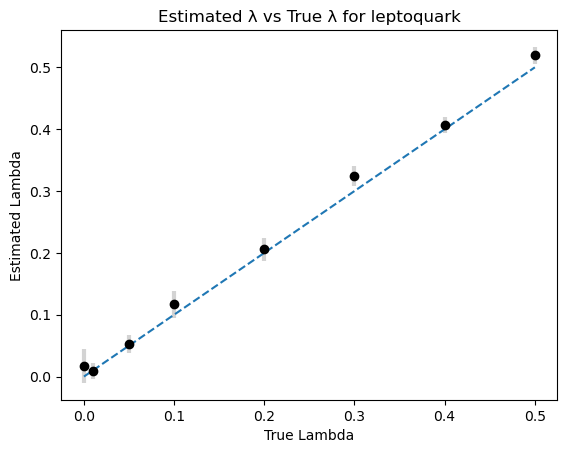

In [94]:
plot_lambda(h5["lambda_mean_dict"].to_dict(), h5["lambda_std_dict"].to_dict(), test_signal)

In [95]:
def plot_lambda_with_baseline(lambda_mean_dict, lambda_std_dict, baseline_mean_dict, baseline_std_dict, signal):
    x_baseline = np.array([float(key) for key in baseline_mean_dict.keys()])
    y_baseline = np.array([baseline_mean_dict[key] for key in baseline_mean_dict.keys()])
    yerr_baseline = np.array([baseline_std_dict[key] for key in baseline_std_dict.keys()])
    plt.plot(x_baseline, y_baseline, label="Baseline")
    plt.fill_between(x_baseline, y_baseline-yerr_baseline, y_baseline+yerr_baseline)
    x = np.array([float(key) for key in lambda_mean_dict.keys()])
    y = np.array([lambda_mean_dict[key] for key in lambda_mean_dict.keys()])
    yerr = np.array([lambda_std_dict[key] for key in lambda_std_dict.keys()])
    plt.errorbar(x, y, yerr=yerr, fmt='o', color='black', ecolor='lightgray', elinewidth=3, label="Embedding")
    true_x = np.linspace(0, np.max(x), 10)
    plt.plot(true_x, true_x, '--')
    plt.xlabel("True Lambda")
    plt.ylabel("Estimated Lambda")
    plt.title("Estimated λ vs True λ for {}".format(signal))
    plt.legend()
    plt.show()

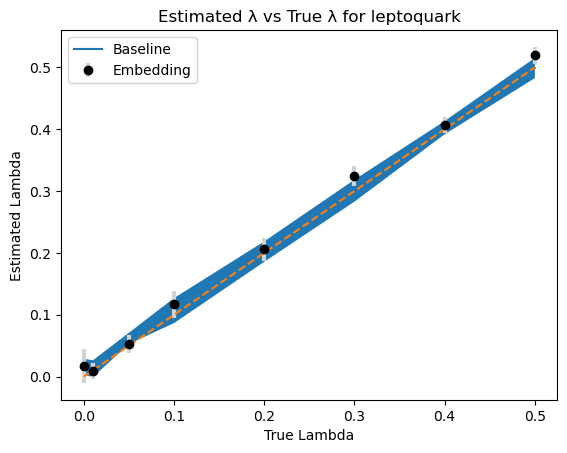

In [96]:
plot_lambda_with_baseline(h5["lambda_mean_dict"].to_dict(), h5["lambda_std_dict"].to_dict(), h5_baseline["lambda_mean_dict"].to_dict(), h5_baseline["lambda_std_dict"].to_dict(), test_signal)

In [97]:
h5["power_df"].iloc[:,0].to_dict()

{'LRT Permutation': 0.1,
 'LRT Bootstrap': 0.0,
 'AUC Permutation': 0.2,
 'AUC Bootstrap': 0.2,
 'MCE Permutation': 0.1,
 'MCE Bootstrap': 0.1}

In [98]:
import seaborn as sns

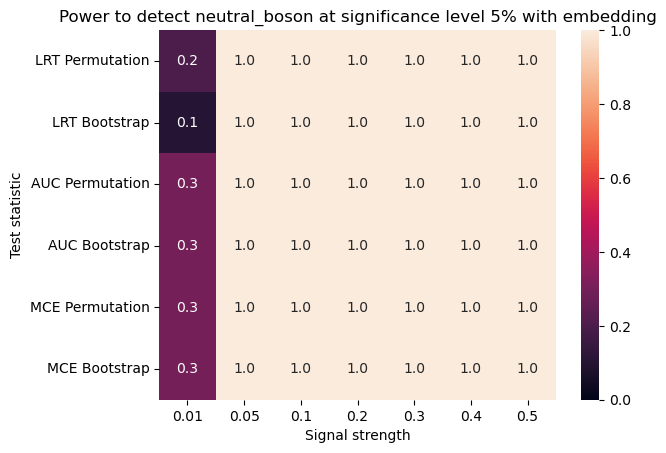

In [118]:
ax = plt.axes()
sns.heatmap(h5["power_df"].iloc[:,1:], annot=True, fmt=".1f", vmin=0, vmax=1)

ax.set_title("Power to detect {} at significance level {:.0%} with embedding".format(test_signal, 0.05))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

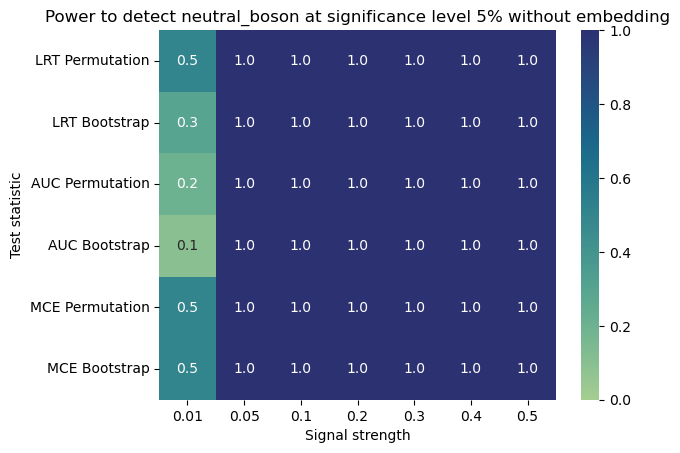

In [119]:
ax = plt.axes()
sns.heatmap(h5_baseline["power_df"].iloc[:,1:], annot=True, fmt=".1f", vmin=0, vmax=1, cmap="crest")

ax.set_title("Power to detect {} at significance level {:.0%} without embedding".format(test_signal, 0.05))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

In [67]:
def plot_type_one_error(signals):
    test_statistics = ['LRT', 'AUC', 'MCE']
    power_df_dicts = []
    baseline_power_df_dicts = []
    for signal in signals:
        h5file_name = "mlp_lambda_estimator_{}.h5".format(signal)
        baseline_h5file_name = "baseline_lambda_estimator_{}.h5".format(signal)
        h5 = pd.HDFStore(h5file_name, "r")
        h5_baseline = pd.HDFStore(baseline_h5file_name, "r")
        power_df_dicts.append(h5["power_df"].iloc[:,0].to_dict())
        baseline_power_df_dicts.append(h5_baseline["power_df"].iloc[:,0].to_dict())
    average_power_dict = {}
    for key in power_df_dicts[0].keys():
        average_power_dict[key] = np.mean([power_df_dict[key] for power_df_dict in power_df_dicts])
    average_baseline_power_dict = {}
    for key in baseline_power_df_dicts[0].keys():
        average_baseline_power_dict[key] = np.mean([baseline_power_df_dict[key] for baseline_power_df_dict in baseline_power_df_dicts])

    permutation_power = [average_power_dict[key+' Permutation'] for key in test_statistics]
    bootstrap_power = [average_power_dict[key+' Bootstrap'] for key in test_statistics]
    baseline_permutation_power = [average_baseline_power_dict[key+' Permutation'] for key in test_statistics]
    baseline_bootstrap_power = [average_baseline_power_dict[key+' Bootstrap'] for key in test_statistics]
    x_axis = np.arange(len(test_statistics))
    width = 0.2
    plt.bar(x_axis - width/2, baseline_permutation_power, width, label='Baseline Permutation')
    plt.bar(x_axis + width/2, baseline_bootstrap_power, width, label='Baseline Bootstrap')
    plt.scatter(x_axis - width/2, permutation_power, label='Embedding Permutation')
    plt.scatter(x_axis + width/2, bootstrap_power, label='Embedding Bootstrap')
    plt.xticks(x_axis, test_statistics)
    plt.xlabel("Test Statistic")
    plt.ylabel("Probability to detect signal when signal is absent") 
    plt.title("Type I Error")
    plt.legend()
    plt.show()


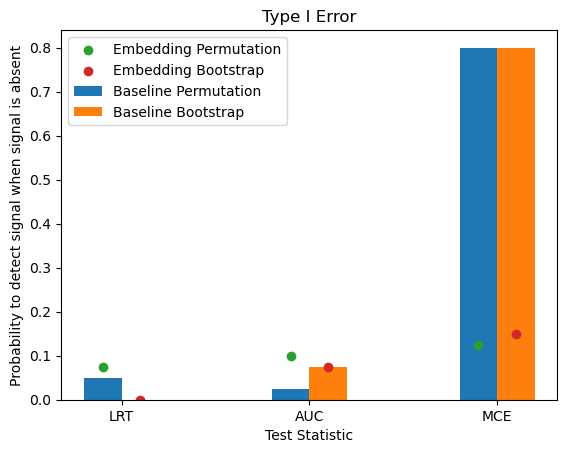

In [68]:
plot_type_one_error(signals)

In [69]:
for signal in signals:
    h5file_name = "mlp_lambda_estimator_{}.h5".format(signal)
    baseline_h5file_name = "baseline_lambda_estimator_{}.h5".format(signal)
    h5 = pd.HDFStore(h5file_name, "r")
    h5_baseline = pd.HDFStore(baseline_h5file_name, "r")
    print(h5["power_df"].iloc[:,0].to_dict())
    print(h5_baseline["power_df"].iloc[:,0].to_dict())

{'LRT Permutation': 0.2, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.0, 'AUC Bootstrap': 0.0, 'MCE Permutation': 0.1, 'MCE Bootstrap': 0.2}
{'LRT Permutation': 0.1, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.1, 'AUC Bootstrap': 0.1, 'MCE Permutation': 0.8, 'MCE Bootstrap': 0.8}
{'LRT Permutation': 0.1, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.2, 'AUC Bootstrap': 0.2, 'MCE Permutation': 0.1, 'MCE Bootstrap': 0.1}
{'LRT Permutation': 0.0, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.0, 'AUC Bootstrap': 0.0, 'MCE Permutation': 0.9, 'MCE Bootstrap': 0.9}
{'LRT Permutation': 0.0, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.1, 'AUC Bootstrap': 0.1, 'MCE Permutation': 0.1, 'MCE Bootstrap': 0.1}
{'LRT Permutation': 0.0, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.0, 'AUC Bootstrap': 0.1, 'MCE Permutation': 0.9, 'MCE Bootstrap': 0.9}
{'LRT Permutation': 0.0, 'LRT Bootstrap': 0.0, 'AUC Permutation': 0.1, 'AUC Bootstrap': 0.0, 'MCE Permutation': 0.2, 'MCE Bootstrap': 0.2}
{'LRT Permutation': 0.1, 'L

# Interpreting classifier

In [2]:
from sklearn.decomposition import PCA

In [3]:
gradient = {}
cov = {}
pca_dict = {}
for test_signal in signals:
    h5file_name = "gradient_{}.h5".format(test_signal)
    h5 = pd.HDFStore(h5file_name, "r")
    gradient[test_signal] = h5["gradient"]
    cov[test_signal] = h5["covariance_matrix"]
    pca = PCA(n_components=None)
    pca.fit(h5["covariance_matrix"])
    pca_dict[test_signal] = pca


In [4]:
for signal in signals:
    print(signal)
    print(pca_dict[signal].explained_variance_ratio_)
    print(pca_dict[signal].explained_variance_ratio_.sum())
    print(pca_dict[signal].components_)
    print(pca_dict[signal].singular_values_)

neutral_boson
[9.79475733e-01 2.04782048e-02 4.60624692e-05 5.61354666e-34]
1.0
[[ 0.49886978  0.51227734 -0.49430659 -0.49432971]
 [-0.48251754  0.43303423  0.51893518 -0.55710363]
 [ 0.63136621  0.29824764  0.65301095  0.29326056]
 [ 0.34595156 -0.67904465  0.24483457 -0.59939296]]
[3.39796669e+00 4.91324270e-01 2.33021441e-02 8.13468884e-17]
leptoquark
[9.67447852e-01 3.13086605e-02 1.24348744e-03 1.06442234e-34]
1.0
[[-0.51555869  0.49389588  0.48075793 -0.5090559 ]
 [-0.38045775 -0.5497271   0.60887634  0.42699136]
 [-0.58332618  0.3913159  -0.4161351   0.57743746]
 [-0.49918103 -0.54839661 -0.47431319 -0.47445385]]
[2.95898885e+00 5.32306525e-01 1.06084088e-01 3.10374860e-17]
neutral_Higgs
[9.19574041e-01 6.81335349e-02 1.22924242e-02 1.51809085e-34]
1.0
[[-0.47491608  0.59245062  0.33152647 -0.55995284]
 [-0.32173014 -0.22719645  0.77632881  0.49212303]
 [-0.78516108 -0.45168123 -0.4193734  -0.06026685]
 [ 0.23338063 -0.62719064  0.33396068 -0.66380392]]
[2.00150918e+00 5.448095

## Plot eigenvector

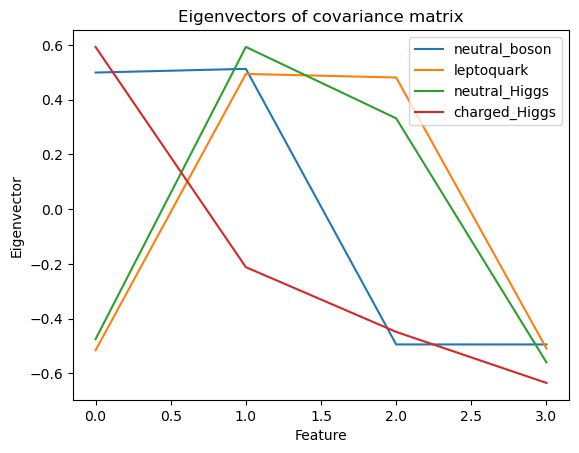

In [5]:
# Plot eigenvectors for different signals
for signal in signals:
    plt.plot(pca_dict[signal].components_[0], label=signal)
    plt.legend()
    plt.xlabel("Feature")
    plt.ylabel("Eigenvector")
    plt.title("Eigenvectors of covariance matrix")
plt.show()  

In [6]:
sig_color = load_toml_config('sig_color')

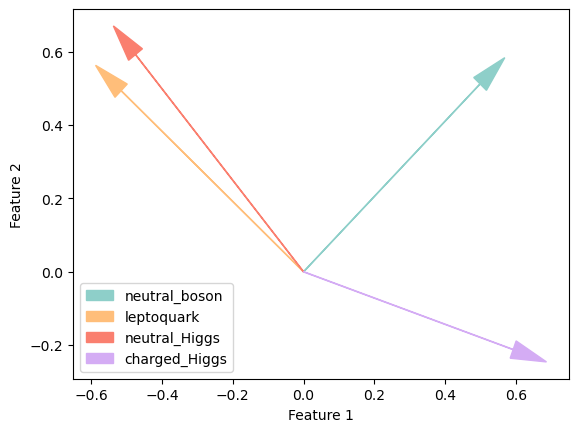

In [7]:
fig=plt.figure()
# ax = plt.axes()
for signal in signals:
    plt.arrow(0, 0, pca_dict[signal].components_[0][0], pca_dict[signal].components_[0][1], head_width=0.05, head_length=0.1, label=signal, color=sig_color[signal])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

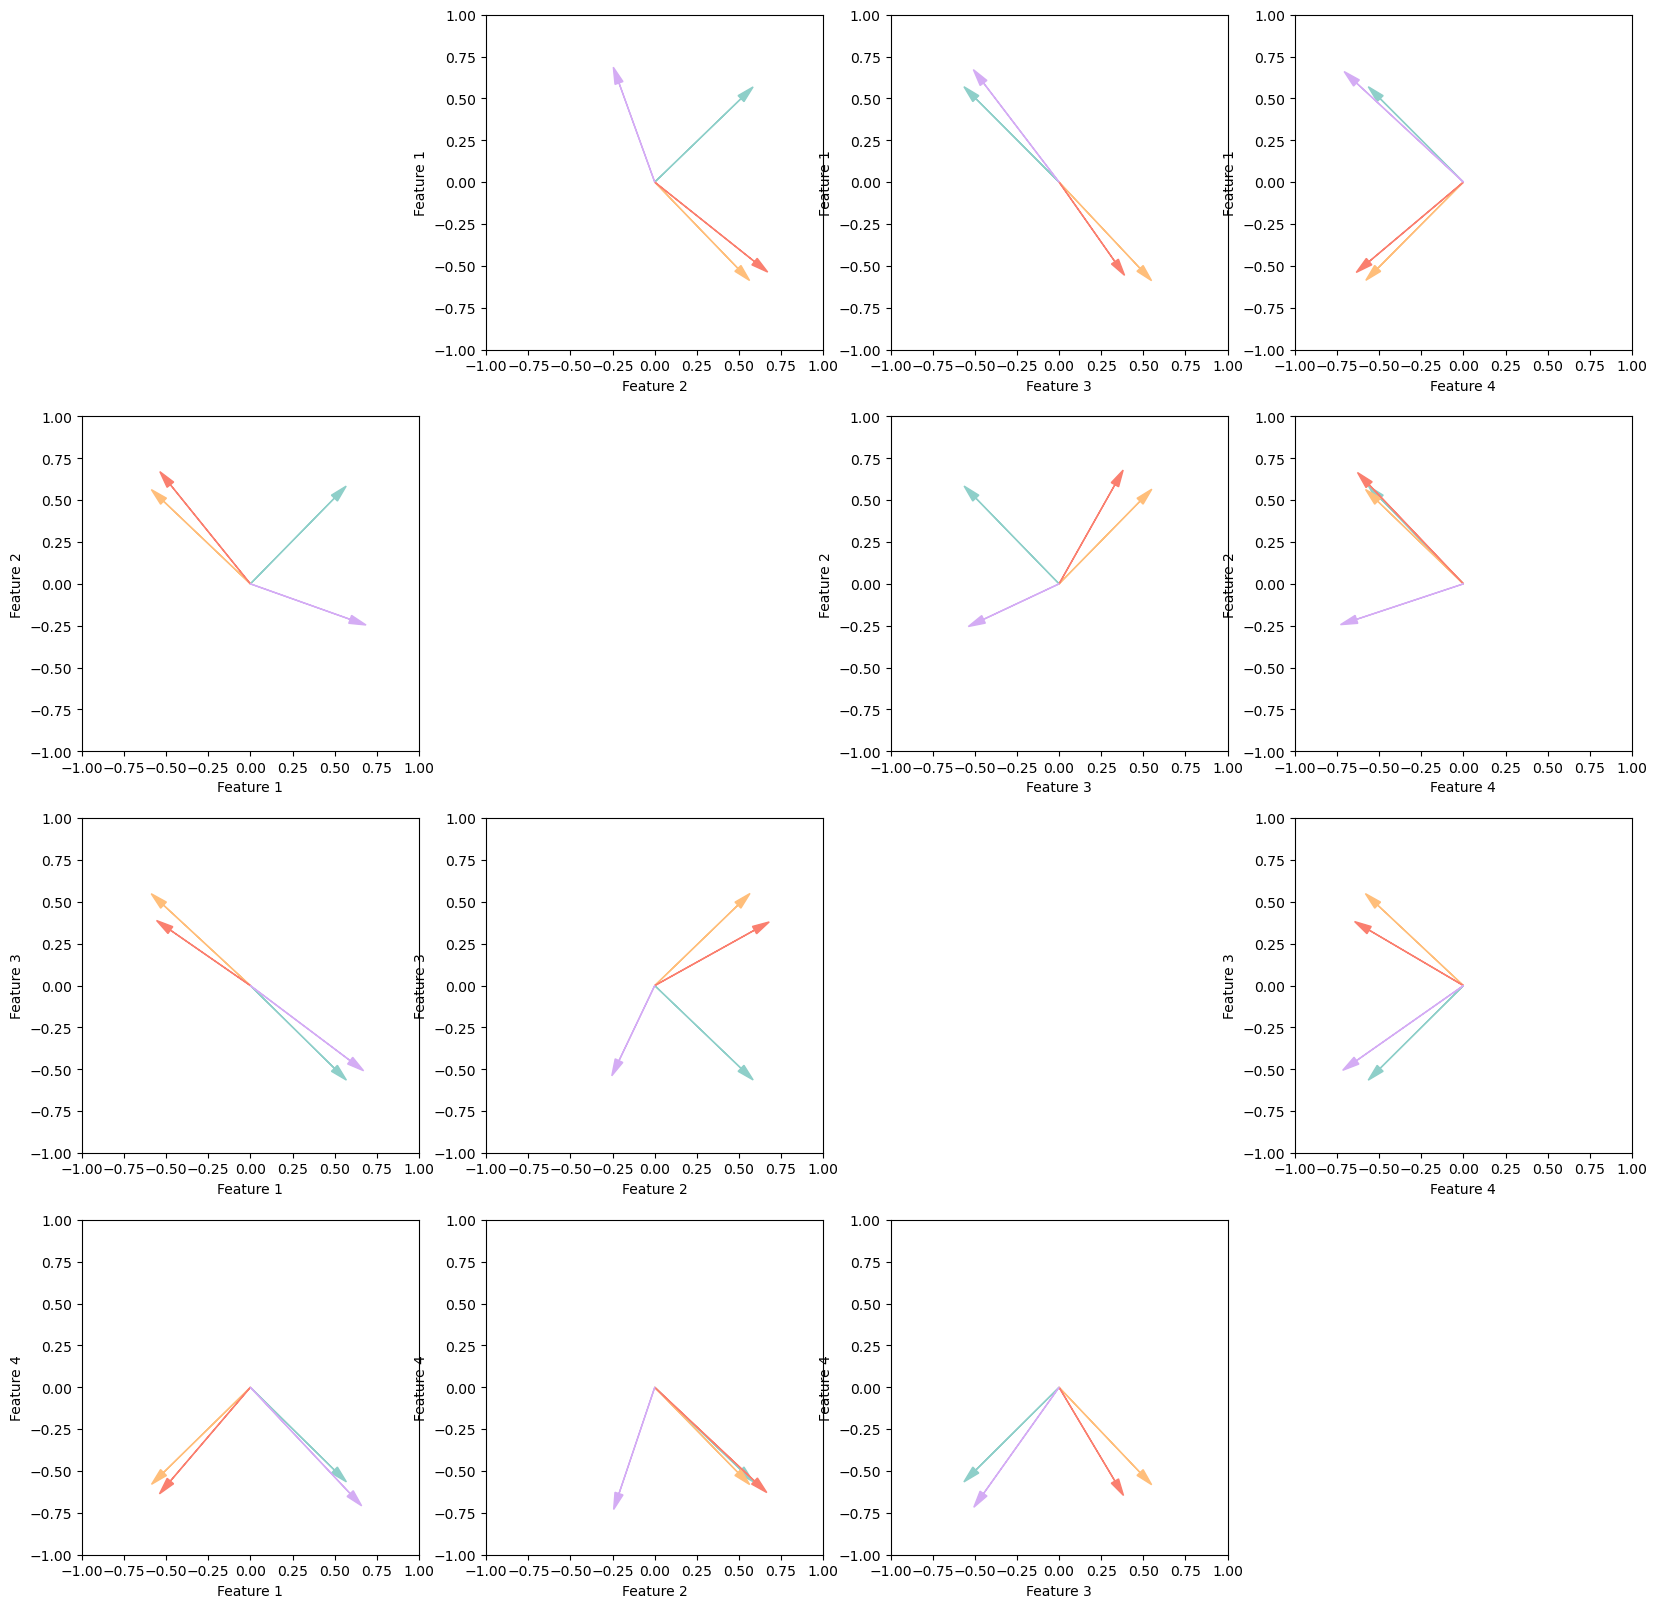

In [35]:
dimension = 4
plt.figure(figsize=(20, 20))
for i in range(dimension):
    for j in range(dimension):
        if i != j:
            plt.subplot(dimension, dimension, i*dimension+j+1)
            plt.xlim(-1, 1)
            plt.ylim(-1, 1)
            for signal in signals:
                plt.arrow(0, 0, pca_dict[signal].components_[0][j], pca_dict[signal].components_[0][i], head_width=0.05, head_length=0.1, label=signal, color=sig_color[signal])
            plt.xlabel("Feature {}".format(j+1))
            plt.ylabel("Feature {}".format(i+1))
# plt.subplot(dimension, dimension, dimension*dimension)
# for signal in signals:
#     plt.arrow(0, 0, pca_dict[signal].components_[0][j], pca_dict[signal].components_[0][i], head_width=0.05, head_length=0.1, label=signal, color=sig_color[signal])
# plt.legend(loc='lower right')
plt.show()

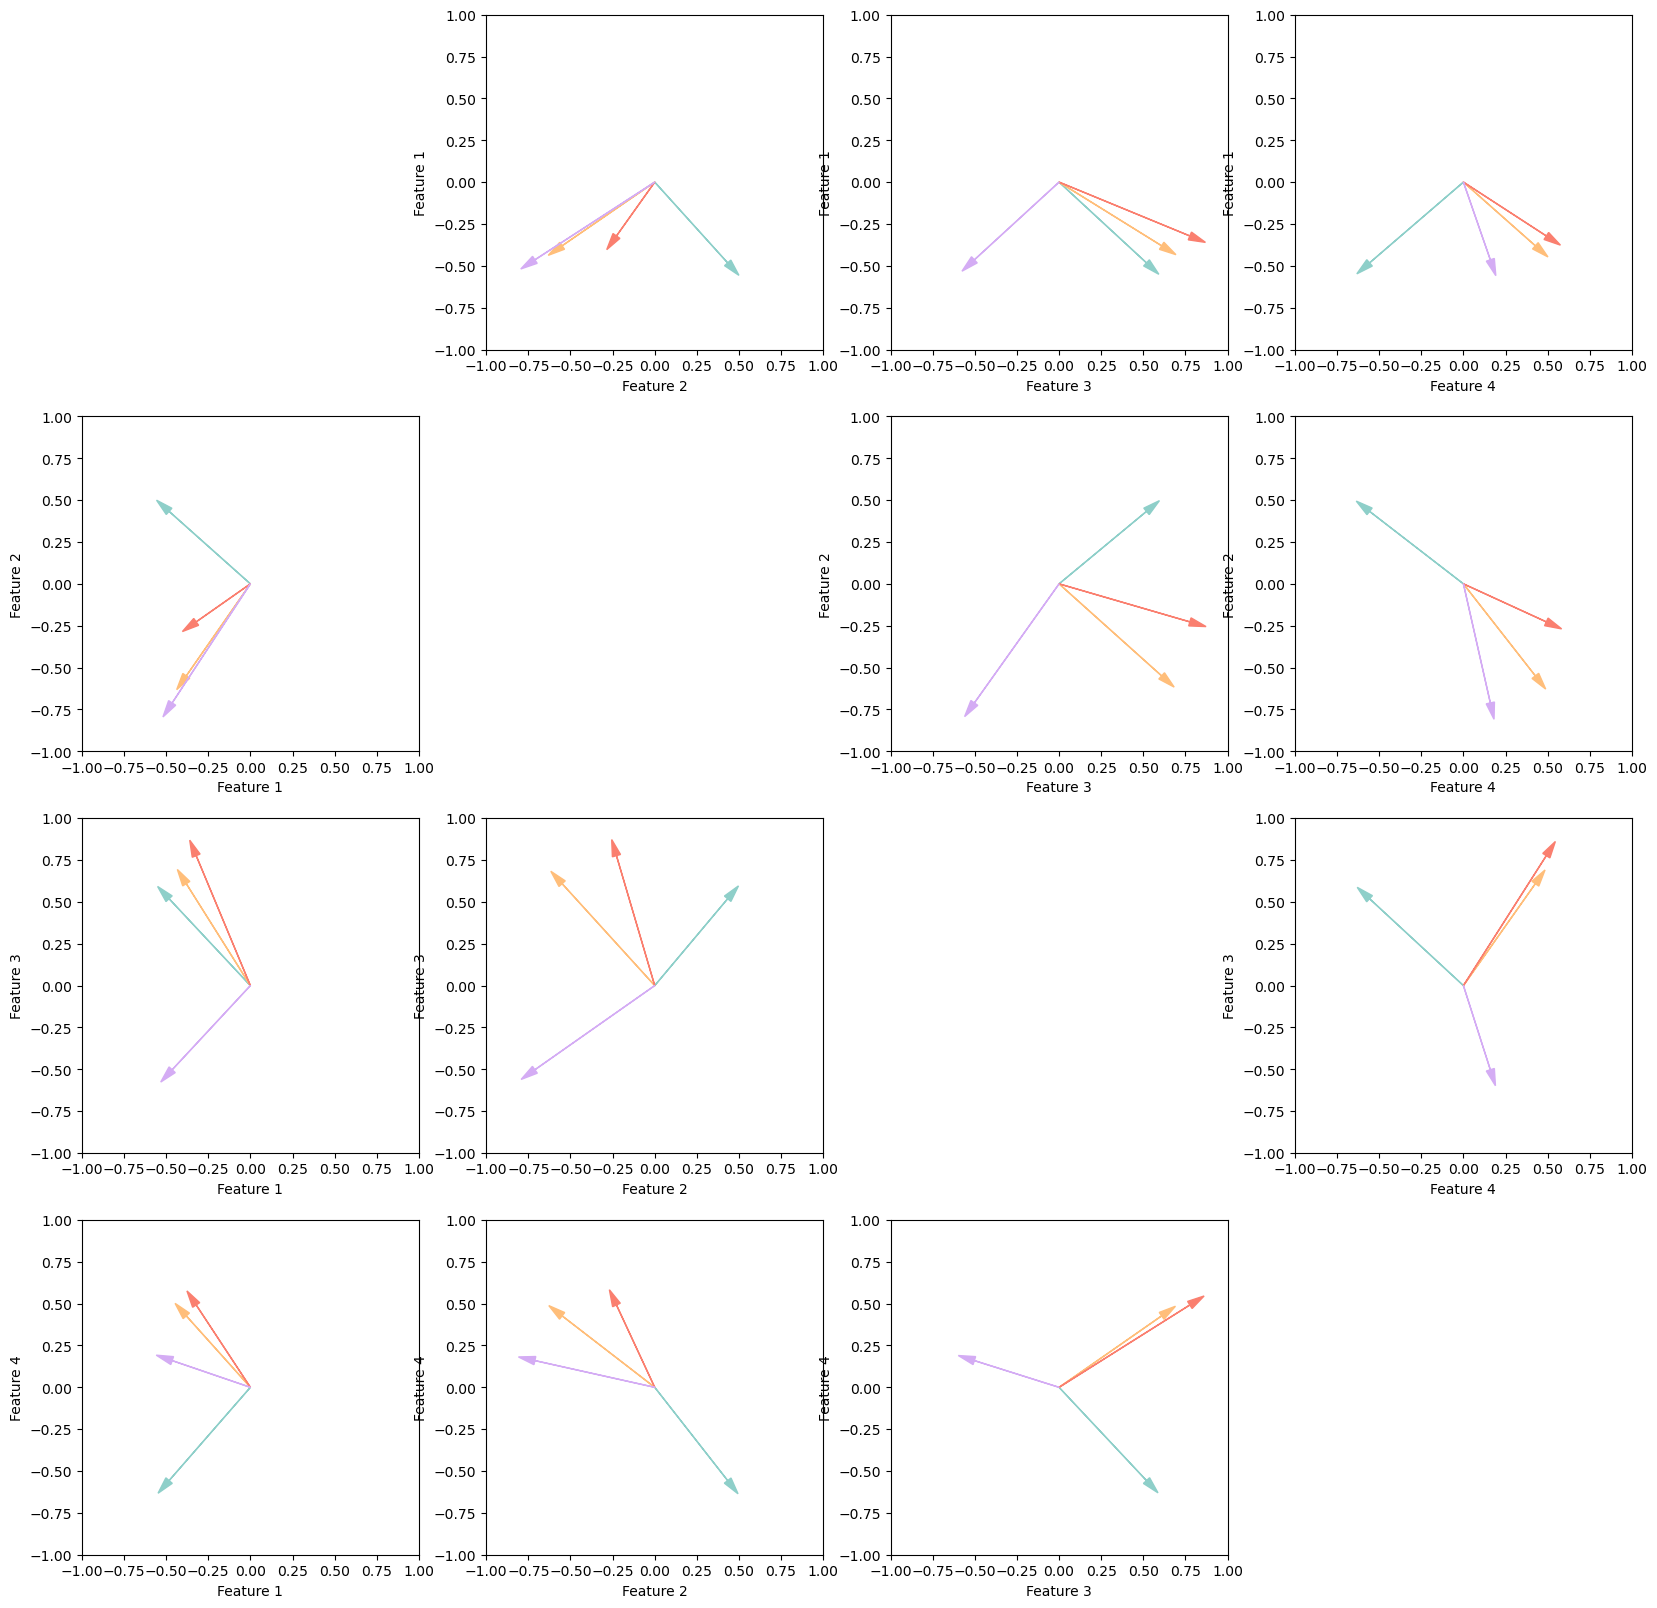

In [36]:
dimension = 4
plt.figure(figsize=(20, 20))
for i in range(dimension):
    for j in range(dimension):
        if i != j:
            plt.subplot(dimension, dimension, i*dimension+j+1)
            plt.xlim(-1, 1)
            plt.ylim(-1, 1)
            for signal in signals:
                plt.arrow(0, 0, pca_dict[signal].components_[1][j], pca_dict[signal].components_[1][i], head_width=0.05, head_length=0.1, label=signal, color=sig_color[signal])
            plt.xlabel("Feature {}".format(j+1))
            plt.ylabel("Feature {}".format(i+1))
# plt.subplot(dimension, dimension, dimension*dimension)
# for signal in signals:
#     plt.arrow(0, 0, pca_dict[signal].components_[0][j], pca_dict[signal].components_[0][i], head_width=0.05, head_length=0.1, label=signal, color=sig_color[signal])
# plt.legend(loc='lower right')
plt.show()

In [46]:
gradient["neutral_boson"]

,type,Gradient on dimension 1,Gradient on dimension 2,Gradient on dimension 3,Gradient on dimension 4
0,neutral_boson,-14.376408,-17.375853,1.936306,10.348309
1,neutral_boson,28.815453,41.238243,-16.738403,-43.740280
2,neutral_boson,-0.846511,3.057292,-0.685180,-4.143948
3,neutral_boson,-1.778719,0.533136,0.921047,-0.659851
4,neutral_boson,-0.245852,1.565986,0.136593,-1.572742
...,...,...,...,...,...
39995,neutral_boson,12.712445,16.377819,-8.051612,-18.698143
39996,neutral_boson,-22.682657,0.345531,1.676579,-11.430948
39997,neutral_boson,-9.078566,-10.101396,1.796742,6.324863
39998,neutral_boson,-0.245852,1.565986,0.136593,-1.572742


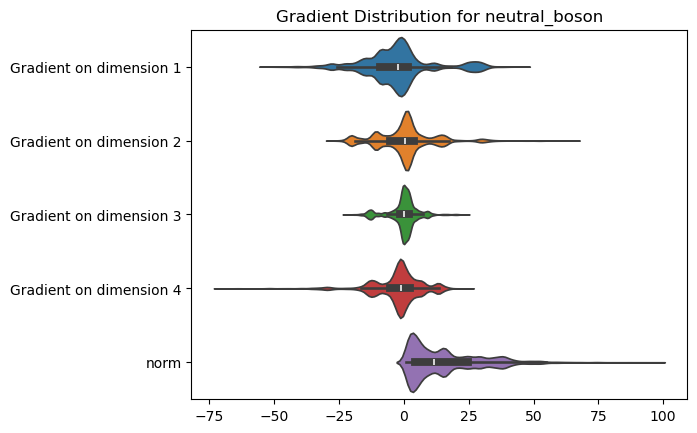

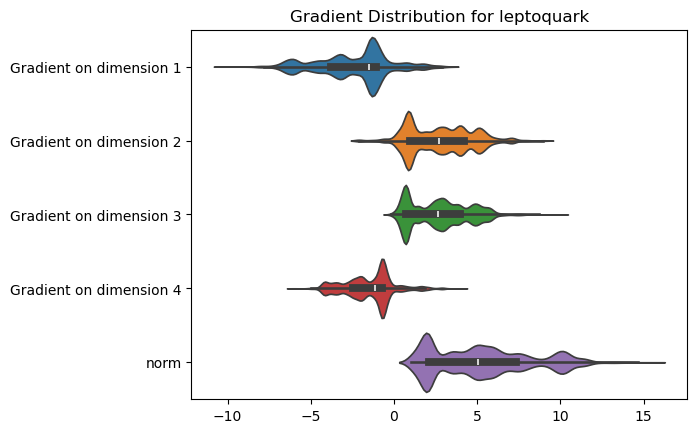

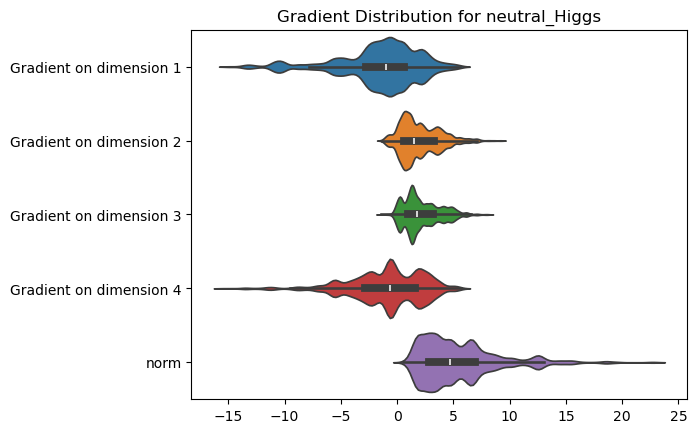

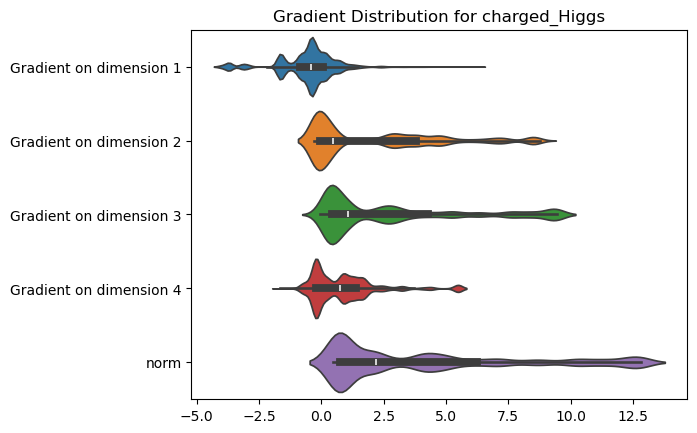

In [8]:
for signal in signals:
    gradient_df = gradient[signal]
    gradient_df['norm'] = gradient_df.iloc[:, 1:].apply(lambda row: np.sqrt(np.sum(row**2)), axis=1)
    gradient[signal] = gradient_df
    sns.violinplot(gradient_df, orient='h')
    plt.title("Gradient Distribution for {}".format(signal))
    plt.show()

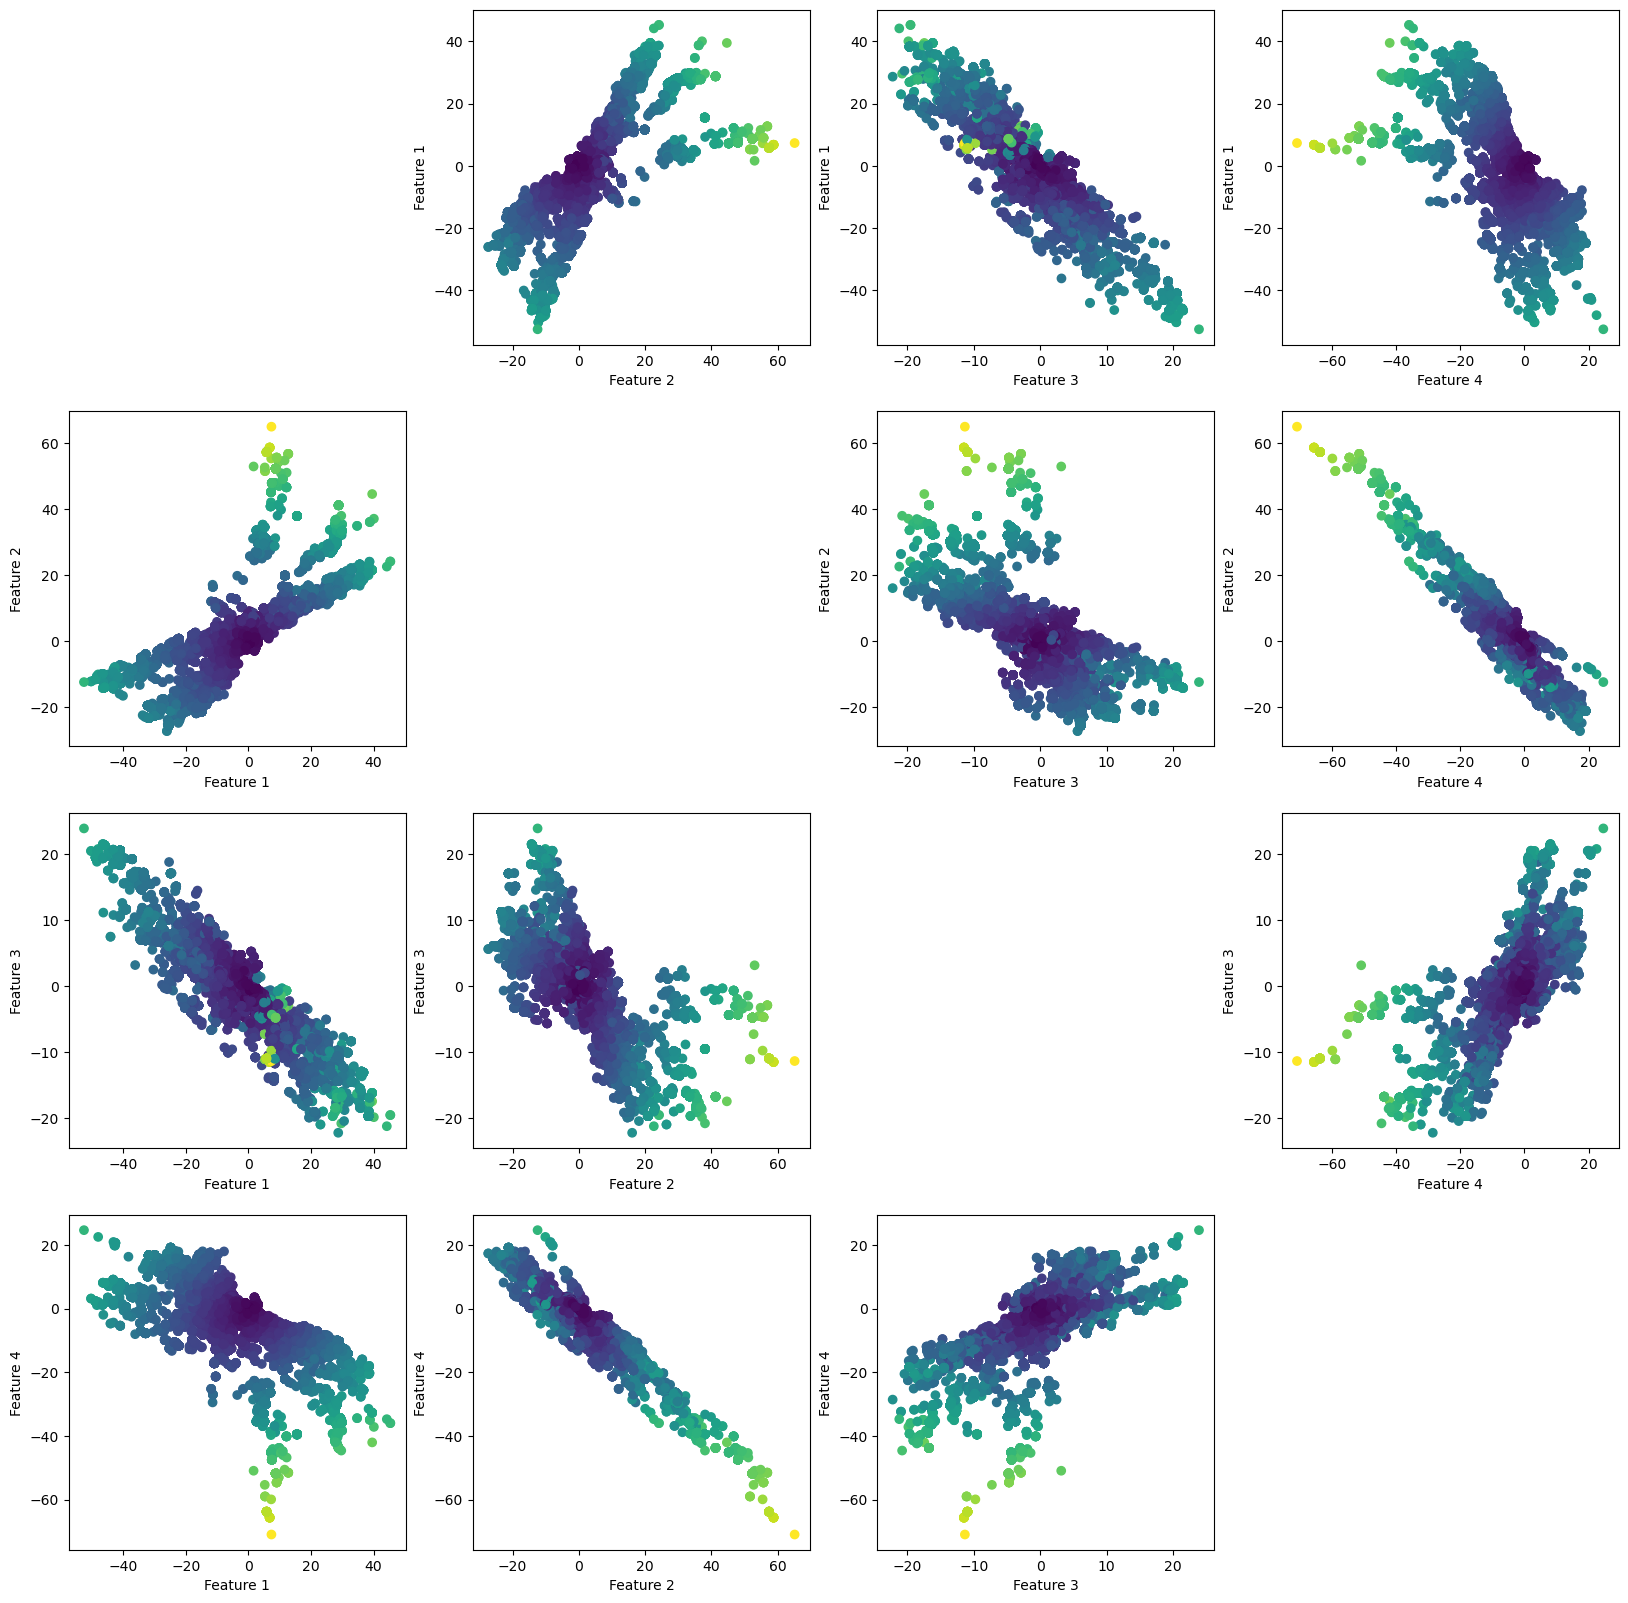

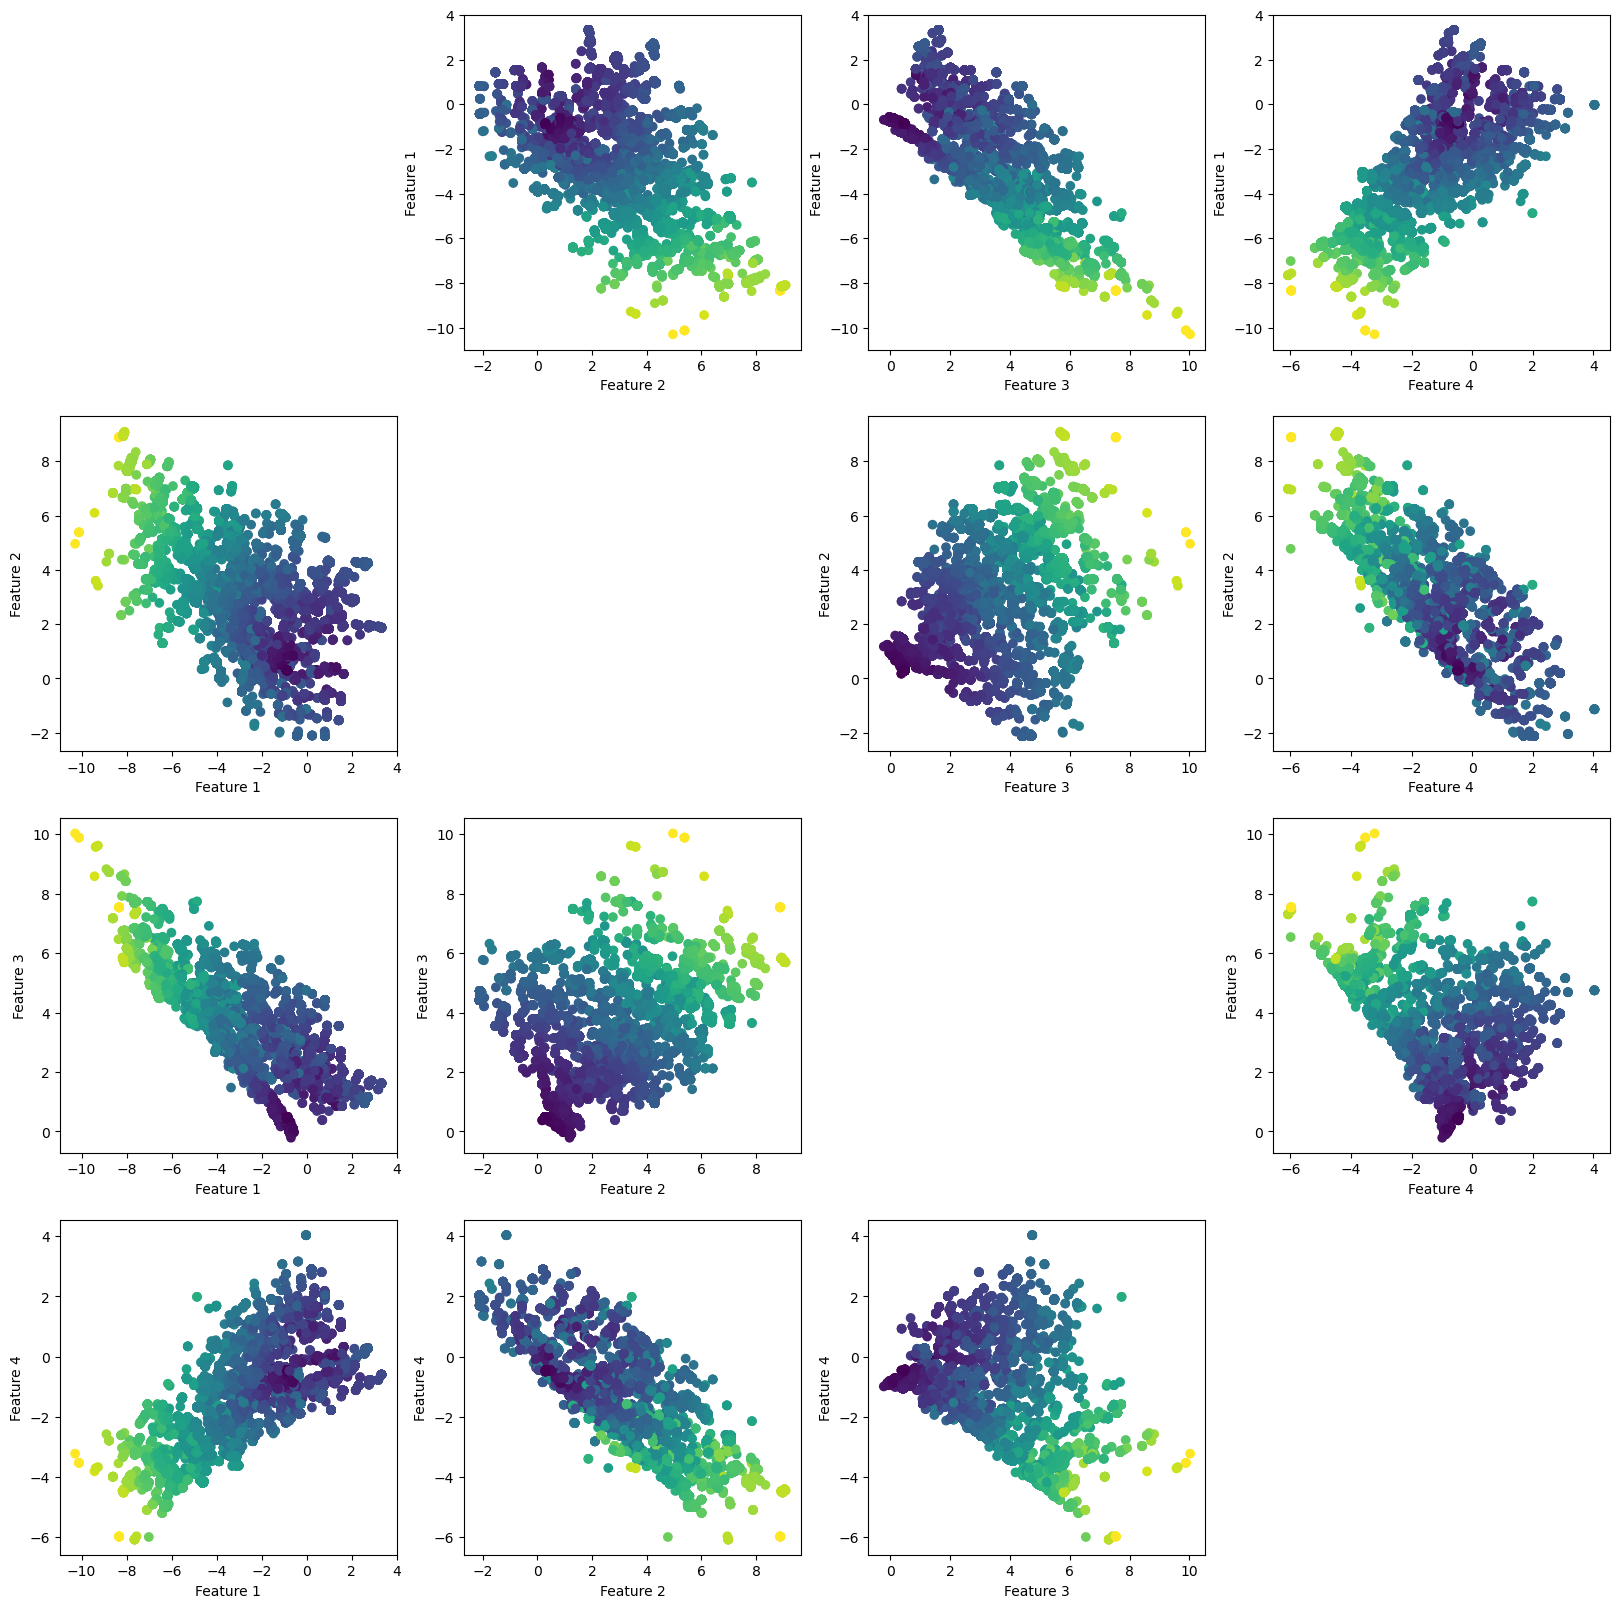

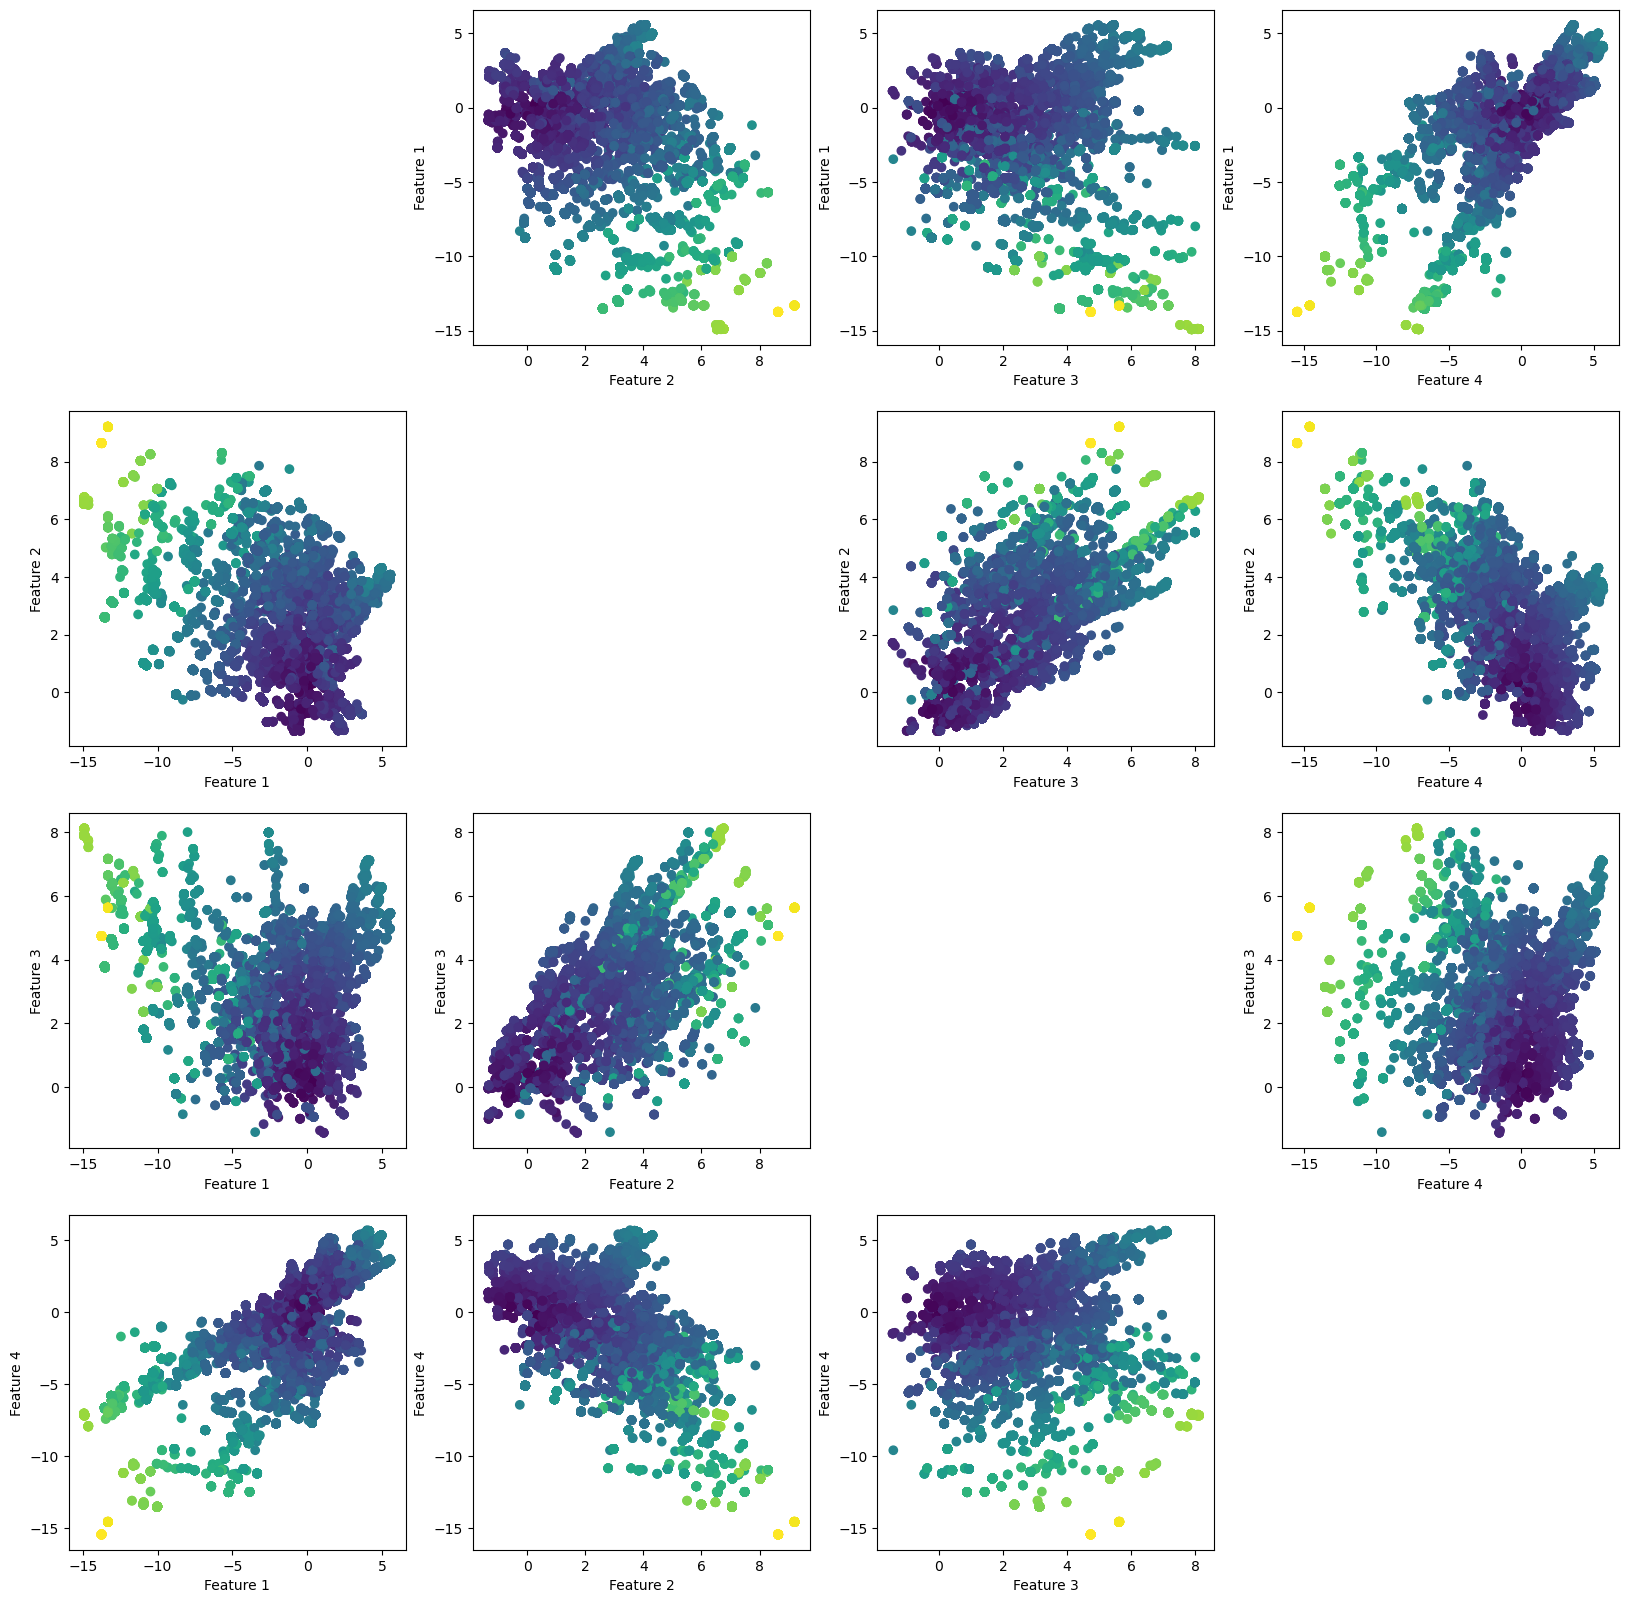

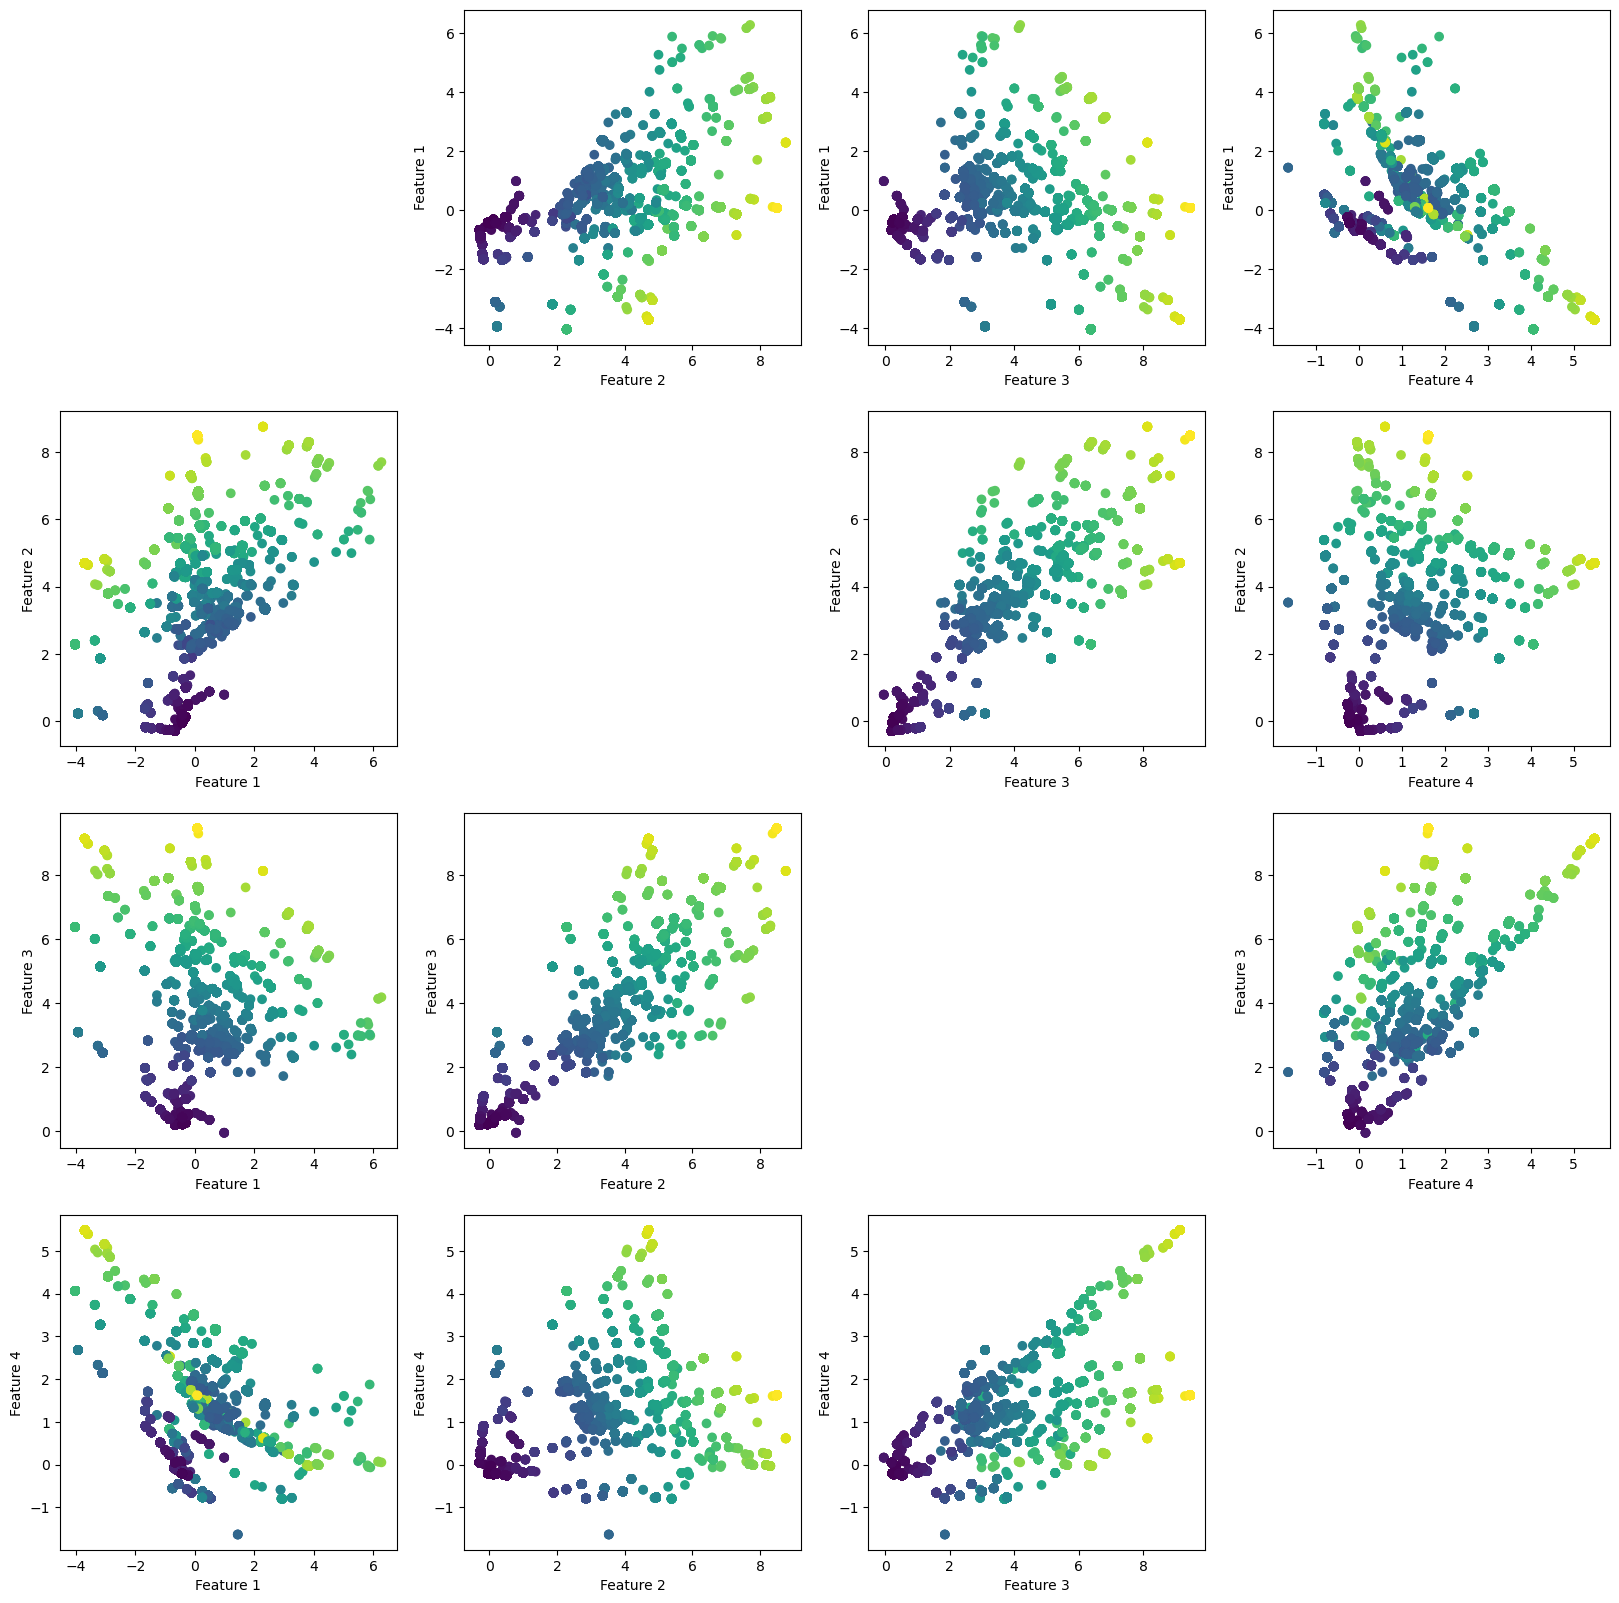

In [51]:
dimension = 4

for signal in signals:
    plt.figure(figsize=(20, 20))
    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                plt.subplot(dimension, dimension, i*dimension+j+1)
                plt.scatter(gradient[signal]["Gradient on dimension {}".format(j+1)], gradient[signal]["Gradient on dimension {}".format(i+1)], c=gradient[signal]['modulus'],cmap='viridis')
                plt.xlabel("Feature {}".format(j+1))
                plt.ylabel("Feature {}".format(i+1))
    plt.show()